In [4]:
%load_ext autoreload
%autoreload 2

add /ssd/users/wergillius/Project/MTtrans to path


In [10]:
import PATH

add /ssd/users/wergillius/Project/MTtrans to path


In [7]:
import numpy as np
import pandas as pd

from scipy import stats
import nupack

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [22]:
my_model=nupack.Model(material='RNA')
nupck_engery_fn = lambda x: nupack.mfe(strands=[x], model=my_model)[0].energy

In [5]:
data_dict = PATH.read_karollus_data()

In [6]:
print(data_dict.keys())

dict_keys(['mpra', 'snv', 'ptr', 'wilhelm', 'andreev', 'pcr3', 'eichhorn', 'doudna', 'varlen_mpra'])


# **the RP datasets**

In [ ]:
RP_293 = data_dict['andreev']
RP_293.to_csv("/data/users/wergillius/UTR_VAE/Alex_framepool/RP_Andreev.csv", index=False)

RP_pcr3 = data_dict['pcr3']
RP_pcr3.to_csv("/data/users/wergillius/UTR_VAE/Alex_framepool/RP_pcr3.csv", index=False)

**compute Sliding window MFE**
```python
python Nupack_covariates.py /data/users/wergillius/UTR_VAE/Alex_framepool/RP_Andreev.csv > andreeev_mfe.log

python Nupack_covariates.py /data/users/wergillius/UTR_VAE/Alex_framepool/RP_pcr3.csv > prc3_mfe.log
```

In [59]:
def compute_GC_ratio(seq):
    n_C = seq.count("C")
    n_G = seq.count("G")
    return (n_C+n_G)/len(seq)

<font size=5 color='#D4B8B4'>**293T, `log_load` is the translation rate**

In [67]:
RP_293 = pd.read_csv("/data/users/wergillius/UTR_VAE/Alex_framepool/RP_Andreev.csv")

In [94]:
for region in ['utr', 'cds', '3utr']:
    RP_293[f'{region}_GC'] = RP_293[region].apply(compute_GC_ratio)
    RP_293[f'{region}_len'] = RP_293[region].apply(lambda x: np.log10(len(x)))

In [233]:
RP_293['utr_num_uAUG'] = RP_293.utr.apply(lambda x : x.count("AUG"))

In [234]:
print(RP_293.shape)
RP_293.head()

(8003, 36)


,GeneName,RefSeq accession number,rpf,"Riboseq arsenite reads, coding(normalised)",Riboseq fold change,Riboseq Z-score,rnaseq_norm,"RNAseq arsenite, reads",RNAseq fold change,RNAseq Z-score,...,3utr_maxmfe,3utr_meanmfe,3utr_minmfe,utr_GC,utr_len,cds_GC,cds_len,3utr_GC,3utr_len,utr_num_uAUG
0,AATK,NM_001080395,17,1.0,na,na,117.8,125,"1,06","-0,54",...,-13.274651,-34.252508,-45.115074,0.682635,2.222716,0.687631,3.581608,0.609290,3.040602,2
1,ARHGEF10L,NM_018125,18,1.0,na,na,124.5,132,"1,06","-0,68",...,-11.980823,-24.837832,-39.559914,0.767296,2.201397,0.628906,3.584331,0.492843,2.689309,1
2,ARMC2,NM_032131,22,1.0,na,na,74.7,79,"1,06","-0,45",...,-4.929226,-10.527352,-14.148799,0.595238,2.225309,0.439324,3.415641,0.300640,2.671173,1
3,ATP6V1C2,NM_144583,20,0.5,na,na,63.2,69,"1,09","-0,27",...,-8.662081,-13.145882,-17.629683,0.788991,2.037426,0.488318,3.108565,0.360465,2.235528,0
4,CACNB4,NM_001145798,13,0.5,na,na,447.3,522,"1,17","0,14",...,0.000000,-10.461172,-19.775108,0.708333,1.857332,0.469848,3.178689,0.318471,2.496930,1


### feature correlation

In [236]:
feature_cols = ['utr_maxmfe', 'utr_meanmfe', 'utr_minmfe', 
                'cds_maxmfe', 'cds_meanmfe', 'cds_minmfe', 
                '3utr_maxmfe', '3utr_meanmfe', '3utr_minmfe', 
                'utr_GC',  'cds_GC',  '3utr_GC',
                'utr_len', 'cds_len', '3utr_len', 'utr_num_uAUG']

correlation_func = lambda x: stats.pearsonr(x, RP_293['log_load'].values)[0]
correlation = np.asarray([correlation_func(RP_293[feat].values) for feat in feature_cols])

# structure corelation to df
correlation_RP_293 = pd.DataFrame(correlation, columns=['pearsonr'])
correlation_RP_293['feature_name'] = feature_cols
correlation_RP_293['region'] = correlation_RP_293['feature_name'].apply(lambda x: x.split("_")[0])

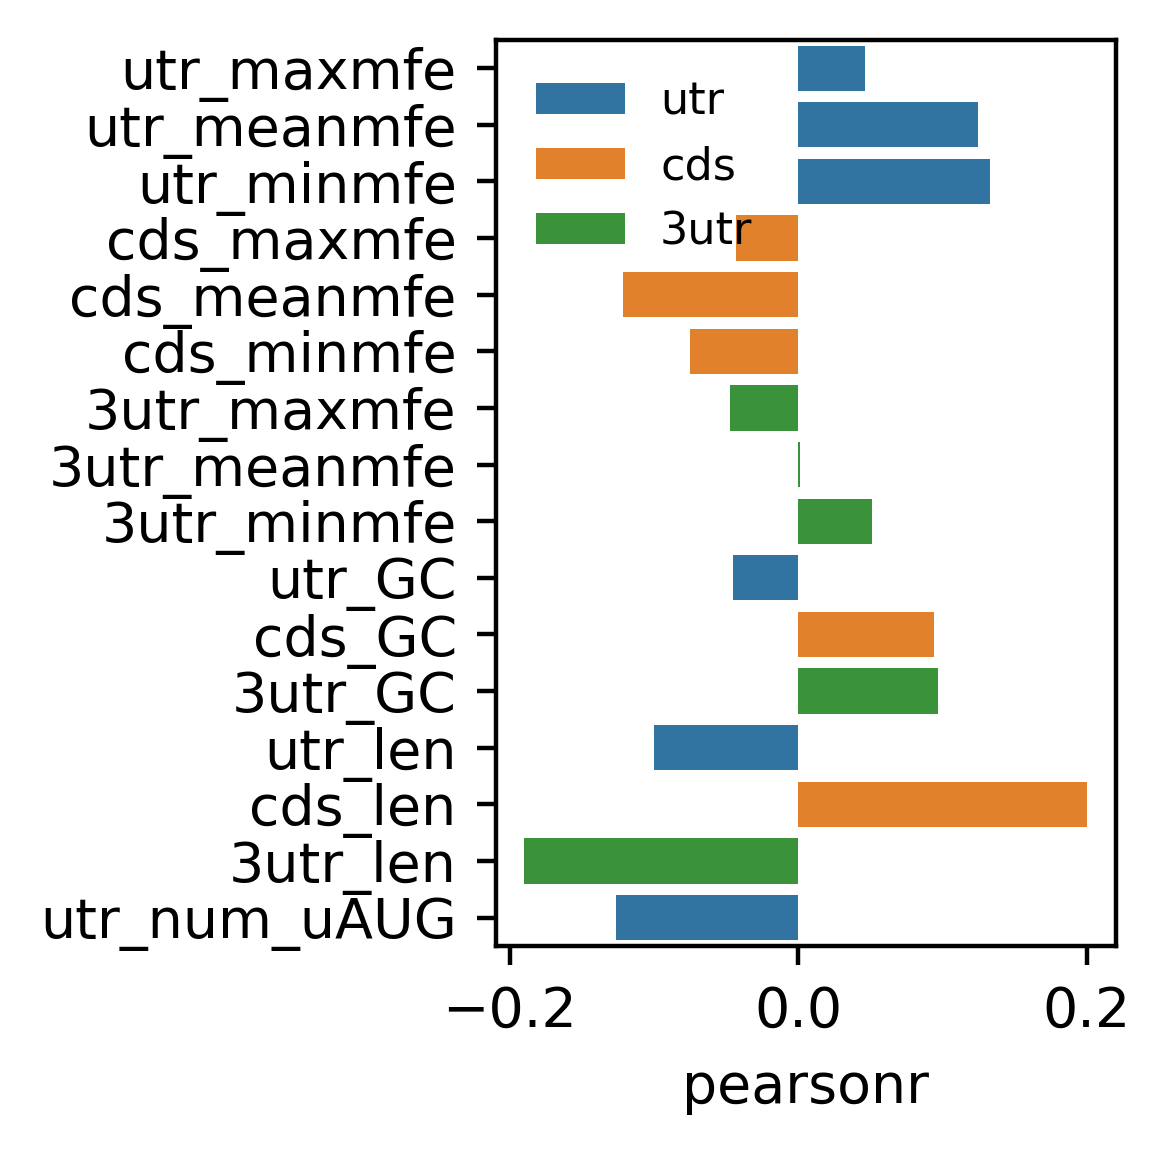

In [237]:
fig, ax = plt.subplots(1,1 , figsize=(2, 3), dpi=400)
sns.barplot(data=correlation_RP_293 , x='pearsonr' , y='feature_name',
            orient='h', hue='region', ax=ax, dodge=False
           )
ax.set_ylabel("")
ax.legend(loc='upper left', frameon=False, fontsize=8)

In [280]:
full_feat_reg = LinearRegression().fit(
    X= RP_293[selec_feat].values, 
    y= RP_293['log_load'].values,
)

In [281]:
full_feat_reg.score(
    X= RP_293[selec_feat].values, 
    y= RP_293['log_load'].values
)

0.11356404830487787

In [288]:
np.sqrt(0.114)

0.33763886032268264

In [282]:
y_pred = full_feat_reg.predict(
    X= RP_293[selec_feat].values,)

Text(0.5, 1.0, '293T RP dataset')

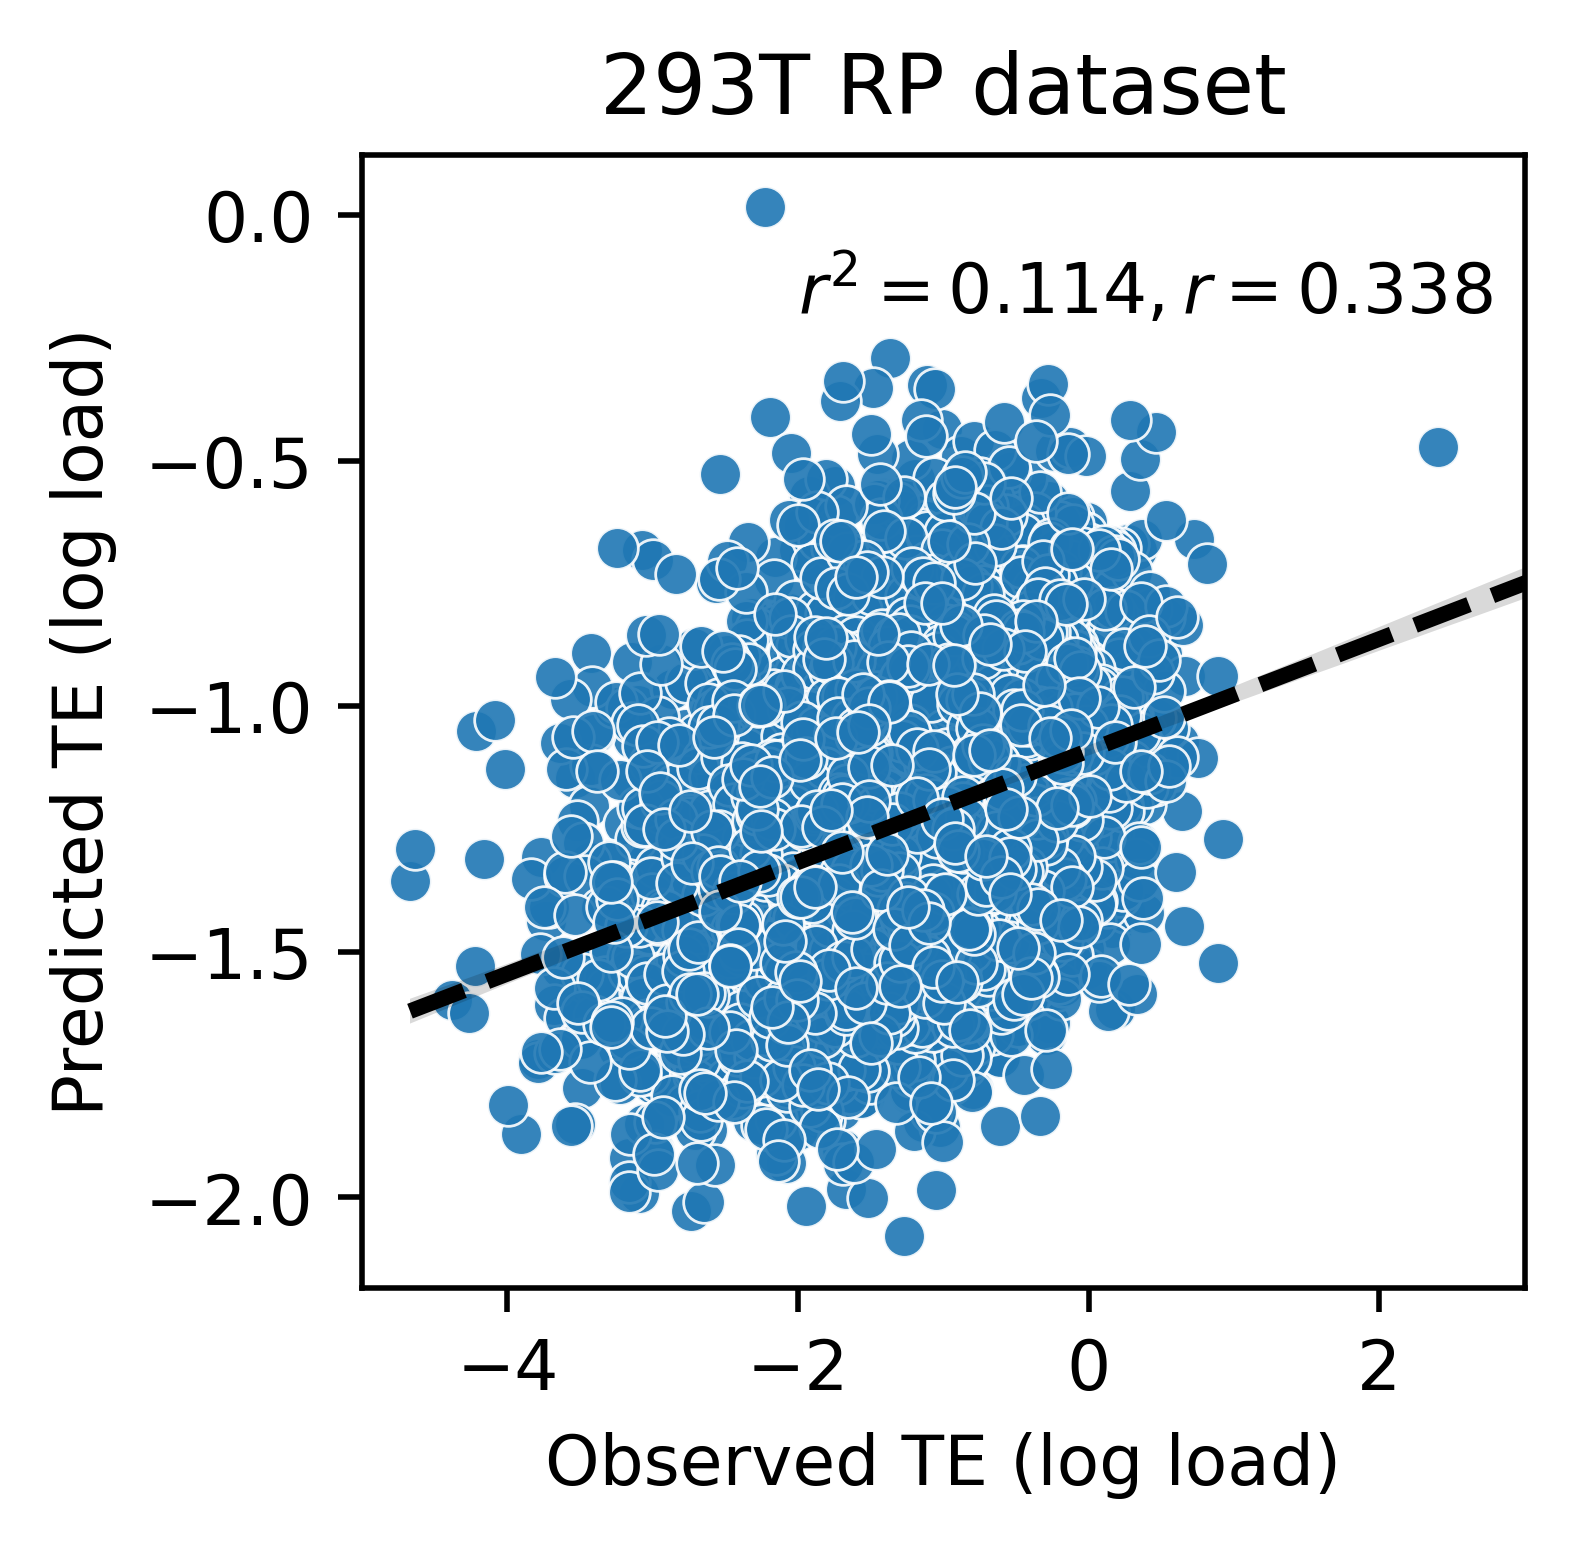

In [292]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=500)
sns.regplot(x=RP_293['log_load'].values, y=y_pred, ax=ax, 
            scatter_kws = {'edgecolor':'white', 'alpha':0.9, 'linewidth':0.4},
            line_kws={"color":"black", 'linestyle':"--"}
           )

ax.set_xlim(-5, 3)
# ax.set_yticks([-4, -2,  0])
ax.text(-2, -0.2, s=r'$r^2=0.114 , r=0.338$')
ax.set_xlabel("Observed TE (log load)")
ax.set_ylabel("Predicted TE (log load)")
ax.set_title("293T RP dataset")

# try more complicated models

split

In [111]:
from sklearn.model_selection import train_test_split

In [125]:
X = RP_293[feature_cols].values
y = RP_293['log_load'].values

In [126]:
X.shape

(8003, 15)

In [127]:
train_x, test_x, train_y, test_y = train_test_split(X, y,  test_size=0.3, random_state=41)

In [128]:
randomfe_reg = RandomForestRegressor(n_estimators=200).fit(train_x, train_y)

In [129]:
randomfe_reg.score(test_x, test_y)

0.13945300494642732

In [130]:
svr_reg = SVR().fit(train_x, train_y)

In [131]:
svr_reg.score(test_x, test_y)

0.09130262027749758

<font size=5 color='B1ACB3'>**PC3,   `log_load` is the translation rate**

In [71]:
RP_PC3=pd.read_csv("/data/users/wergillius/UTR_VAE/Alex_framepool/RP_pcr3.csv")

In [242]:
for region in ['utr', 'cds', '3utr']:
    RP_PC3[f'{region}_GC'] = RP_PC3[region].apply(compute_GC_ratio)
    RP_PC3[f'{region}_len'] = RP_PC3[region].apply(lambda x: np.log10(len(x)))

In [243]:
RP_PC3['utr_num_uAUG'] = RP_PC3.utr.apply(lambda x : x.count("AUG"))

In [244]:
print(RP_PC3.shape)
RP_PC3.head()

(7672, 43)


,EnsemblGeneID,control1(mRNA),control2(mRNA),treat1(mRNA),treat2(mRNA),control1(RPF),control2(RPF),treat1(RPF),treat2(RPF),control1(mRNA)_normalized,...,3utr_maxmfe,3utr_meanmfe,3utr_minmfe,utr_GC,utr_len,cds_GC,cds_len,3utr_GC,3utr_len,utr_num_uAUG
0,ENSG00000000419,1054,967,992,888,234,481,383,306,1014.34,...,-5.281172,-10.892155,-15.246397,0.666667,1.431364,0.412516,2.893762,0.256604,2.423246,0
1,ENSG00000000457,71,75,139,95,12,17,17,15,68.33,...,-6.332774,-17.622097,-40.675991,0.609302,2.332438,0.450411,3.315340,0.376286,3.610873,1
2,ENSG00000000460,191,162,199,201,45,88,63,37,183.81,...,-2.917857,-14.432168,-29.629200,0.423631,2.540329,0.420765,3.408579,0.354986,3.038620,6
3,ENSG00000000971,81,2,88,11,31,7,36,2,77.95,...,-7.458759,-9.984085,-12.509411,0.395833,2.380211,0.398268,3.567732,0.277487,2.281033,1
4,ENSG00000001036,756,445,736,568,124,195,204,127,727.55,...,-6.927678,-17.225139,-25.046173,0.785714,1.748188,0.482906,3.147367,0.351562,2.952308,0


test these corr

In [245]:
feature_cols = ['utr_maxmfe', 'utr_meanmfe', 'utr_minmfe', 
                'cds_maxmfe', 'cds_meanmfe', 'cds_minmfe', 
                '3utr_maxmfe', '3utr_meanmfe', '3utr_minmfe', 
                'utr_GC',  'cds_GC',  '3utr_GC',
                'utr_len', 'cds_len', '3utr_len', 'utr_num_uAUG']

correlation_func = lambda x: stats.pearsonr(x, RP_PC3['log_load'].values)[0]
correlation = np.asarray([correlation_func(RP_PC3[feat].values) for feat in feature_cols])

# structure corelation to df
correlation_RP_PC3 = pd.DataFrame(correlation, columns=['pearsonr'])
correlation_RP_PC3['feature_name'] = feature_cols
correlation_RP_PC3['region'] = correlation_RP_PC3['feature_name'].apply(lambda x: x.split("_")[0])

In [246]:
correlation_RP_PC3

,pearsonr,feature_name,region
0,0.081714,utr_maxmfe,utr
1,0.181868,utr_meanmfe,utr
2,0.178931,utr_minmfe,utr
3,0.099184,cds_maxmfe,cds
4,0.271138,cds_meanmfe,cds
5,0.190629,cds_minmfe,cds
6,0.042387,3utr_maxmfe,3utr
7,0.251829,3utr_meanmfe,3utr
8,0.253924,3utr_minmfe,3utr
9,-0.187255,utr_GC,utr


In [247]:
from matplotlib import pyplot as plt
import seaborn as sns

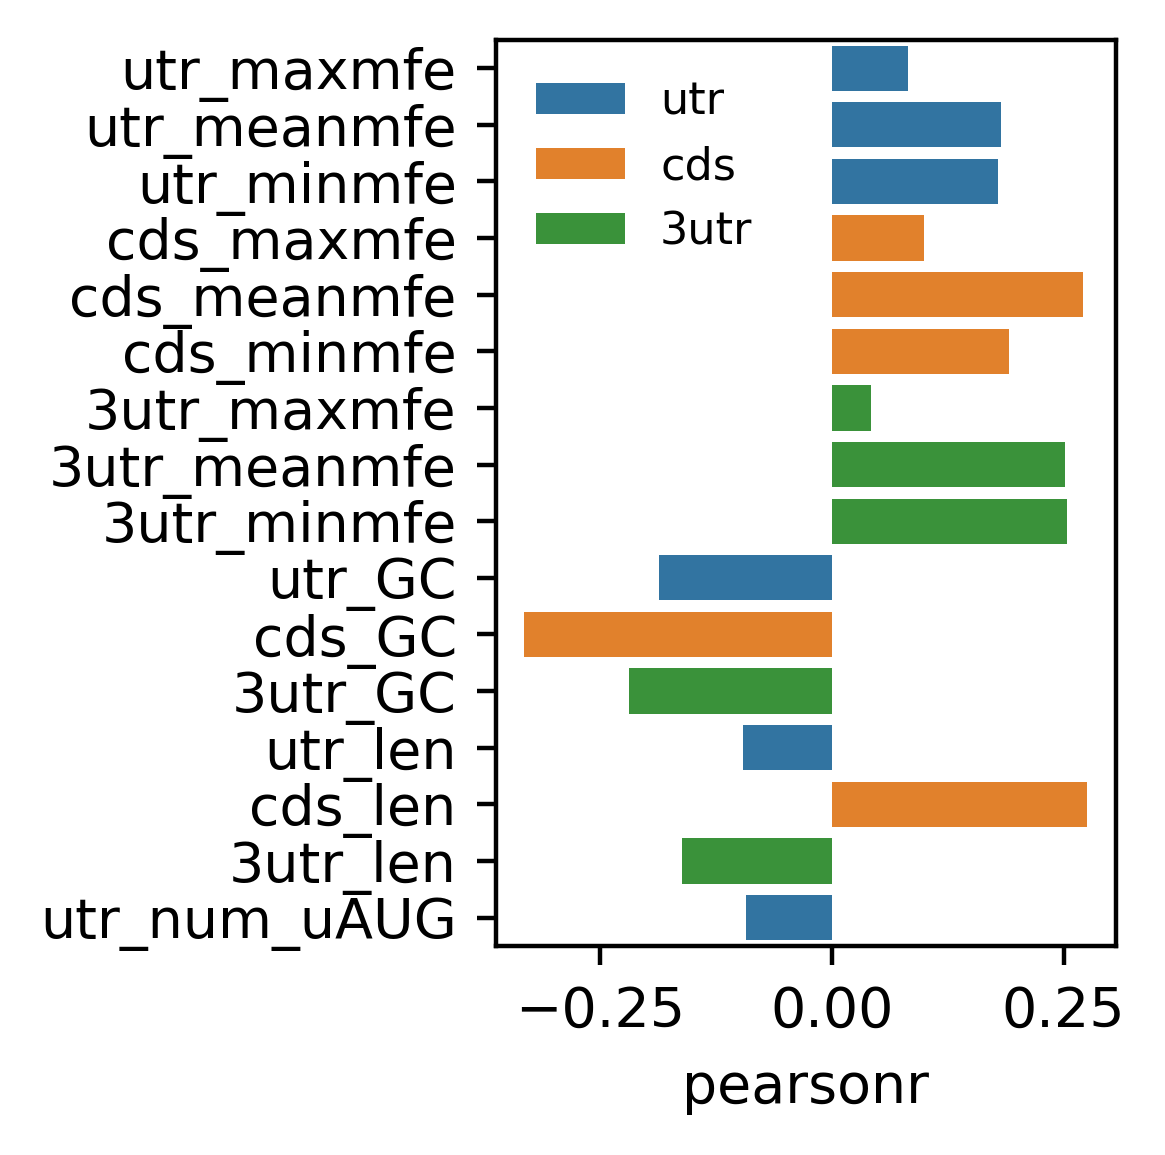

In [248]:
fig, ax = plt.subplots(1,1 , figsize=(2, 3), dpi=400)
sns.barplot(data=correlation_RP_PC3 , x='pearsonr' , y='feature_name',
            orient='h', hue='region', ax=ax, dodge=False
           )
ax.set_ylabel("")
ax.legend(loc='upper left', frameon=False, fontsize=8)

In [294]:
fullRP_PC3_reg = LinearRegression().fit(
    X= RP_PC3[feature_cols].values, 
    y= RP_PC3['log_load'].values,
)

In [297]:
y_pred_PC3 =fullRP_PC3_reg.predict(
    X= RP_PC3[feature_cols].values, 
)

In [296]:
fullRP_PC3_reg.score(
    X= RP_PC3[feature_cols].values, 
    y= RP_PC3['log_load'].values
)

0.2852952608783387

In [269]:
np.sqrt(0.285)

0.5338539126015656

In [274]:
len(feature_cols)

16

Text(0.5, 1.0, 'PCR3 RP dataset')

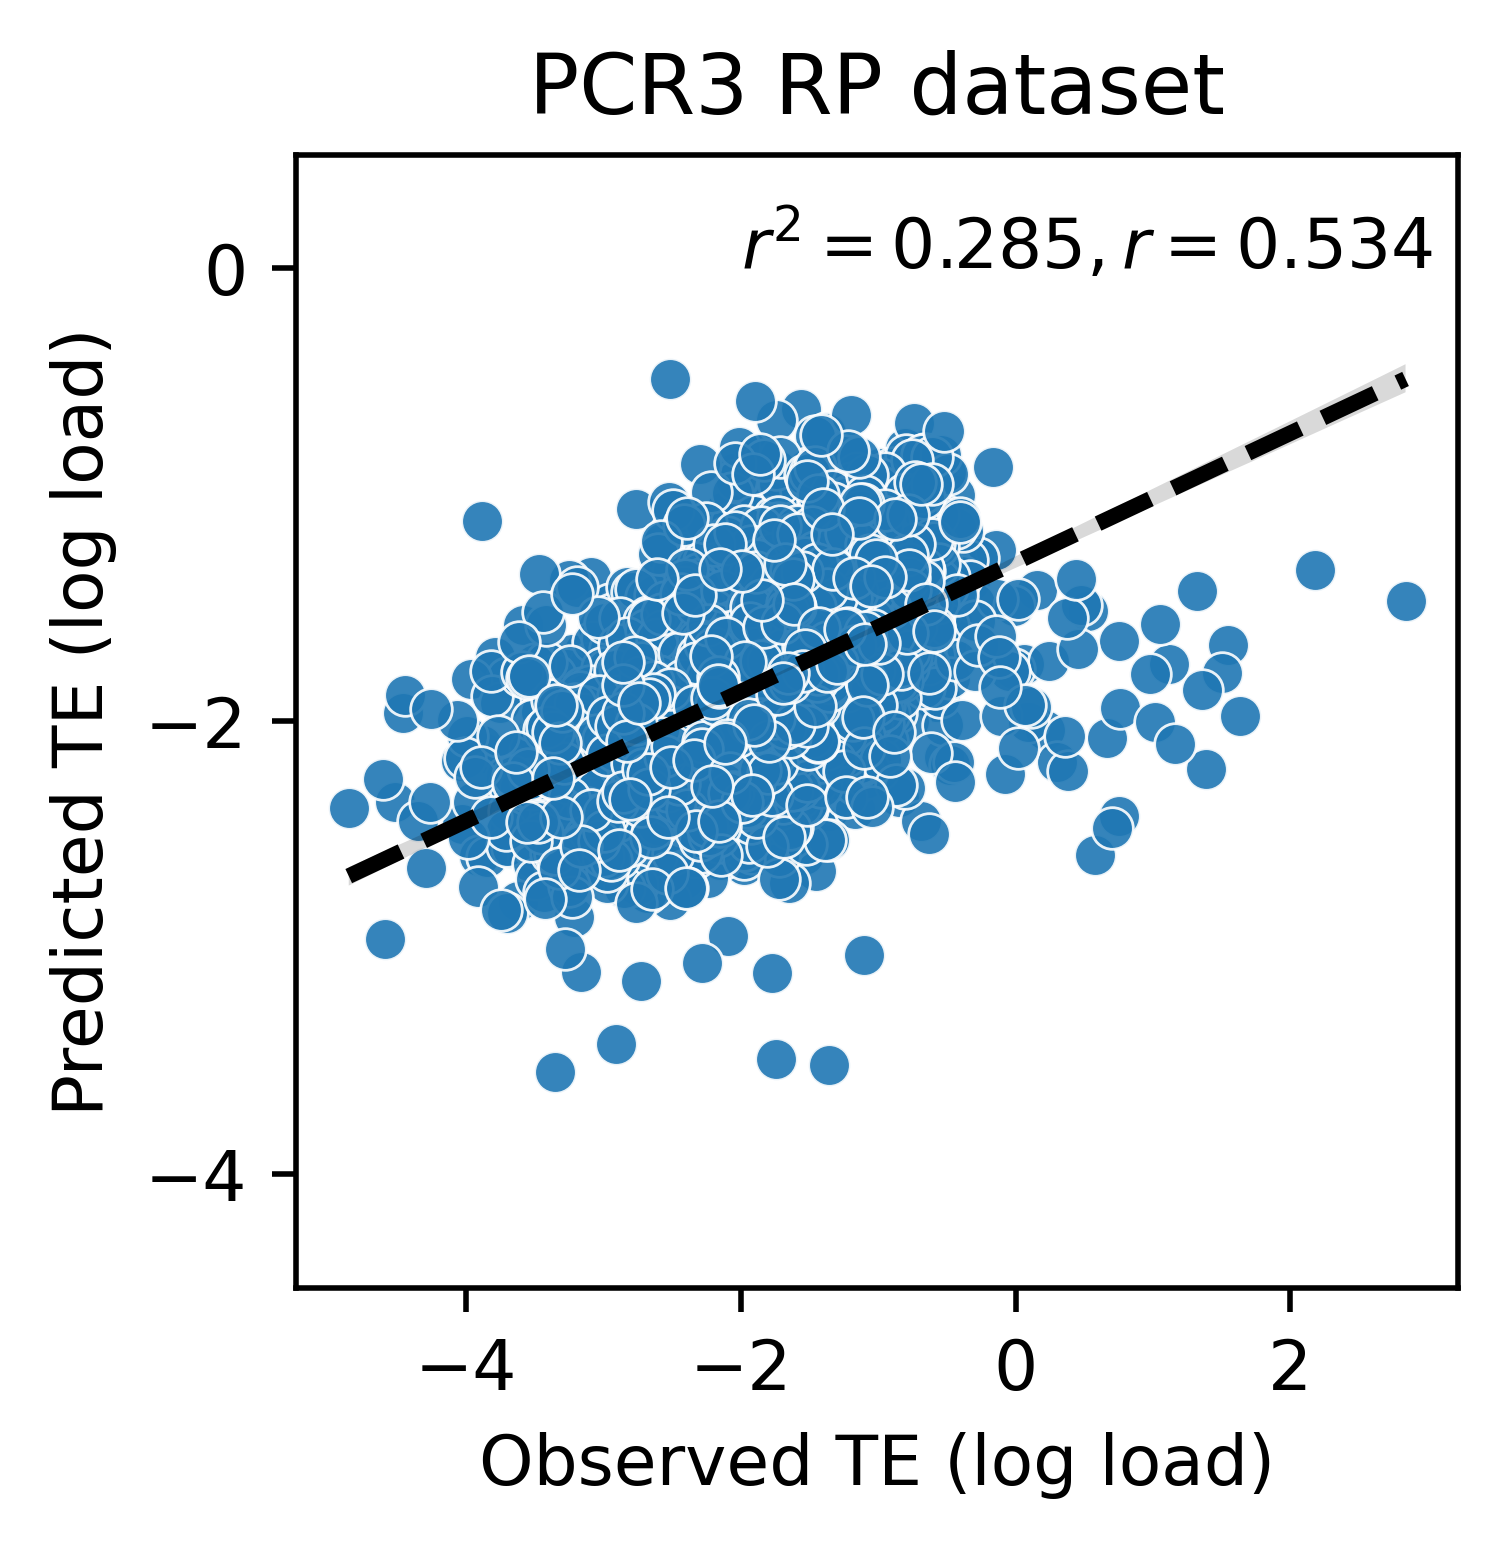

In [298]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=500)
sns.regplot(x=RP_PC3['log_load'].values, y=y_pred_PC3, ax=ax, 
            scatter_kws = {'edgecolor':'white', 'alpha':0.9, 'linewidth':0.4},
            line_kws={"color":"black", 'linestyle':"--"}
           )

ax.set_ylim(-4.5, 0.5)
ax.set_yticks([-4, -2,  0])
ax.text(-2, 0, s=r'$r^2=0.285 , r=0.534$')
ax.set_xlabel("Observed TE (log load)")
ax.set_ylabel("Predicted TE (log load)")
ax.set_title("PCR3 RP dataset")

In [163]:
np.sqrt(0.228)

0.4774934554525329

## PTR_data

- ptr : Eraslan
- wilhelm : Wilhelm

In [144]:
data_dict['ptr'].to_csv("/data/users/wergillius/UTR_VAE/Alex_framepool/PTR_Eraslan.csv", index=False)

In [145]:
data_dict['wilhelm'].to_csv("/data/users/wergillius/UTR_VAE/Alex_framepool/PTR_Wilhelm.csv", index=False)